In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from decimal import Decimal, ROUND_HALF_UP

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

[Coursera Machine Learning (3): ロジスティック回帰、正則化](https://qiita.com/katsu1110/items/e4ef613559f02f183af5)

ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    C：float
      正則化パラメータの逆数(0~1のfloat)

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, verbose, no_bias=False, C=1.0):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        self.C = C
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        #バイアス項を設ける場合、左列に1の列追加
        if self.no_bias == False:
            one = np.ones(X.shape[0]).reshape(-1, 1)
            X = np.concatenate((one, X), axis=1)
            if X_val is not None:
                one = np.ones(X_val.shape[0]).reshape(-1, 1)
                X_val = np.concatenate((one, X_val), axis=1)
        
        #重み初期値：0以上1未満の乱数
        self.coef_ = np.random.rand(X.shape[1])
        #print("初期値:", self.coef_)
        
        for i in range(self.iter):
            #仮定関数の値（hypo_y）
            y_pred = self._logistic_hypothesis(X)
            #誤差の算出 shape(m, 1)
            error = y_pred - y.reshape(-1, 1)
            #重みを更新
            self.coef_ = self._gradient_descent(X, error)
            #print(self.coef_)
            #目的（損失）関数の値
            self.loss[i] = self.objective_func(X, y)
            
            #検証データがある場合のloss値保存
            if X_val is not None:
                self.val_loss[i] = self.objective_func(X_val, y_val)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print("train_loss:\n{}".format(self.loss))
            if X_val is not None:
                print("val_loss:\n{}".format(self.val_loss))
                
    def predict(self, X, threshold=0.5):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        threshold：閾値（初期値0.5）

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        if self.no_bias == False:
            one = np.ones(X.shape[0]).reshape(-1, 1)
            X = np.concatenate((one, X), axis=1)
        
        label = np.array([0]*X.shape[0])
        probability = self.predict_proba(X)
        for i in range(X.shape[0]):
            if probability[i] >= threshold:
                label[i] = 1
            else:
                label[i] = 0
        return label
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        probability = self._logistic_hypothesis(X)
        return probability
    
    def _logistic_hypothesis(self, X):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)　
        訓練データ

        Returns
        -------
        hypo_theta：次の形のndarray, shape (n_samples, 1)　
        ロジスティック回帰の仮定関数による推定結果
        確率が返っている    
        """
        #線形回帰の仮定関数
        linear_hypo = np.dot(X, self.coef_.reshape(-1, 1))

        #ロジスティック回帰の仮定関数
        #シグモイド関数を用いて、0〜1間に収まるよう数を変換（あるクラスに属する確率を返す）
        hypo_y = 1 / (1 +  np.exp(-linear_hypo))
        return hypo_y
    
    def _gradient_descent(self, X, error):
        """
        重みの更新
        Parameters
        --------
        X：次の形のndarray, shape (n_samples, n_features)
            訓練データ
        error：仮定関数の値　- 実際の値(n_samples, 1)

        Returns
        --------
        new_coef_：次の形のndarray, shape (1, n_features)
        """
        m = X.shape[0] #サンプル数
        
        new_coef_ = self.coef_ - (self.lr*((1/m)*np.dot(error.reshape(1, -1), X) + (self.C/m)*self.coef_))
        new_coef_ = new_coef_.reshape(-1, )#(coef数, )

        return new_coef_
    
    def objective_func(self, X, y):
        """ 
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          サンプル
        y：次の形のndarray, shape (n_samples,)
          正解値

        Returns
        ----------
        loss : 次の形のndarray, shape (n_samples,)
          損失 numpy.float

        """
        m = X.shape[0] #サンプルサイズ

        loss = (1/m)*np.sum(-y*np.log(self._logistic_hypothesis(X).T) - (1-y)*np.log(1-self._logistic_hypothesis(X).T))\
                   + (self.C/(2*m))*np.sum(np.square(self.coef_))

        return loss

In [3]:
#20200823編集前

def _gradient_descent(self, X, error):
    """
    重みの更新
    Parameters
    --------
    X：次の形のndarray, shape (n_samples, n_features)
        訓練データ
    error：仮定関数の値　- 実際の値(n_samples, 1)

    Returns
    --------
    new_coef_：次の形のndarray, shape (1, n_features)
    """
    m = X.shape[0] #サンプル数

    if self.no_bias == False:
        #左列に1の列追加(切片用)
        one = np.ones(X.shape[0]).reshape(-1, 1)
        X = np.concatenate((one, X), axis=1)
        copy_coef = self.coef_.copy()
        copy_coef[0] = 0
    else:
        copy_coef = self.coef_.copy()

    new_coef_ = self.coef_ - (self.lr*((1/m)*np.dot(error.reshape(1, -1), X) + (1/self.L)*copy_coef)) #(coef数, )

    return new_coef_

### 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。


ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。

In [4]:
#確認用
def logistic_hypothesis(X):
    """
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)　m×n行列
    訓練データ

    Returns
    -------
    hypo_theta：
    ロジスティック回帰の仮定関数による推定結果
    確率が返っている    
    """
    #線形回帰の仮定関数
    linear_hypo = np.dot(X, coef_.reshape(-1, 1))

    #ロジスティック回帰の仮定関数
    #シグモイド関数を用いて、0〜1間に収まるよう数を変換（あるクラスに属する確率を返す）
    hypo_y = 1 / (1 +  np.exp(-linear_hypo))
    return hypo_y

### 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。  
以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。

In [5]:
#確認用
def gradient_descent(X, error):
    """
    重みの更新
    Parameters
    --------
    X：次の形のndarray, shape (n_samples, n_features)
        訓練データ
    error：仮定関数の値　- 実際の値(n_samples, 1)

    Returns
    --------
    new_coef_：次の形のndarray, shape (1, n_features)
    """
    m = X.shape[0] #サンプル数
    C = 1.0

    new_coef_ = coef_ - (0.05*((1/m)*np.dot(error.reshape(1, -1), X) + (C/m)*coef_)) #(coef数, )

    return new_coef_

### 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。


仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

### 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。


なお、この数式には正則化項が含まれています。


＊数式が見切れる場合、DIVERを全画面にして御覧ください。

In [6]:
#確認用
def objective_func(X, y):
    """ 
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      サンプル
    y：次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    loss : 次の形のndarray, shape (n_samples,)
      損失 numpy.float

    """
    m = X.shape[0] #サンプルサイズ
    C = 1.0

    loss = (1/m)*np.sum(-y*np.log(logistic_hypothesis(X).T) - (1-y)*np.log(1-logistic_hypothesis(X).T))\
               + (C/(2*m))*np.sum(np.square(coef_))

    return loss

### 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [7]:
from sklearn.datasets import load_iris

data = load_iris()
X = pd.DataFrame(data.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
y = pd.DataFrame(data.target, columns=["Species"])

df = pd.concat([X, y], axis=1)
df = df.query("Species == [1, 2]")
display(df.head())
display(df.tail())

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


,sepal_length,sepal_width,petal_length,petal_width,Species
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [8]:
X = df.iloc[:, 0:4].values
y = df.loc[:, "Species"].values
y = np.where(y==1, 0, 1) #ラベルを0, 1に変換
display(X)
display(y)

array([[7. , 3.2, 4.7, 1.4],
       [6.4, 3.2, 4.5, 1.5],
       [6.9, 3.1, 4.9, 1.5],
       [5.5, 2.3, 4. , 1.3],
       [6.5, 2.8, 4.6, 1.5],
       [5.7, 2.8, 4.5, 1.3],
       [6.3, 3.3, 4.7, 1.6],
       [4.9, 2.4, 3.3, 1. ],
       [6.6, 2.9, 4.6, 1.3],
       [5.2, 2.7, 3.9, 1.4],
       [5. , 2. , 3.5, 1. ],
       [5.9, 3. , 4.2, 1.5],
       [6. , 2.2, 4. , 1. ],
       [6.1, 2.9, 4.7, 1.4],
       [5.6, 2.9, 3.6, 1.3],
       [6.7, 3.1, 4.4, 1.4],
       [5.6, 3. , 4.5, 1.5],
       [5.8, 2.7, 4.1, 1. ],
       [6.2, 2.2, 4.5, 1.5],
       [5.6, 2.5, 3.9, 1.1],
       [5.9, 3.2, 4.8, 1.8],
       [6.1, 2.8, 4. , 1.3],
       [6.3, 2.5, 4.9, 1.5],
       [6.1, 2.8, 4.7, 1.2],
       [6.4, 2.9, 4.3, 1.3],
       [6.6, 3. , 4.4, 1.4],
       [6.8, 2.8, 4.8, 1.4],
       [6.7, 3. , 5. , 1.7],
       [6. , 2.9, 4.5, 1.5],
       [5.7, 2.6, 3.5, 1. ],
       [5.5, 2.4, 3.8, 1.1],
       [5.5, 2.4, 3.7, 1. ],
       [5.8, 2.7, 3.9, 1.2],
       [6. , 2.7, 5.1, 1.6],
       [5.4, 3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
#ScratchLogisticRegression()使用

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

model = ScratchLogisticRegression(num_iter=1000, lr=0.01, verbose=True, no_bias=False)

model.fit(X_train, y_train, X_test, y_test)

train_loss:
[4.04668198 3.88883124 3.73107907 3.57344704 3.41596473 3.25867269
 3.10162648 2.9449023  2.78860451 2.63287588 2.47791125 2.3239756
 2.17142726 2.02074703 1.87257262 1.72773635 1.58730004 1.45257613
 1.32511677 1.20664738 1.09892334 1.00350605 0.92149155 0.85326872
 0.79840252 0.75570156 0.72344924 0.69970736 0.6825882  0.67043318
 0.66189023 0.65591612 0.65173768 0.64879844 0.64670631 0.64518926
 0.64406065 0.64319344 0.6425017  0.64192752 0.64143205 0.64098925
 0.64058171 0.6401978  0.63982978 0.63947248 0.63912245 0.63877741
 0.63843583 0.63809669 0.63775933 0.63742329 0.63708827 0.63675408
 0.63642058 0.63608768 0.63575533 0.63542348 0.63509211 0.63476121
 0.63443075 0.63410074 0.63377116 0.63344202 0.6331133  0.63278502
 0.63245715 0.63212972 0.6318027  0.63147611 0.63114994 0.63082419
 0.63049886 0.63017396 0.62984947 0.6295254  0.62920175 0.62887851
 0.62855569 0.62823329 0.62791131 0.62758973 0.62726858 0.62694784
 0.62662751 0.62630759 0.62598809 0.62566899 0.6253

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
print("予測", model.predict(X_test))
print("正解", y_test)

print("正解率:{}".format(accuracy_score(y_test, model.predict(X_test))))
print("適合率:{}".format(precision_score(y_test, model.predict(X_test))))
print("再現率:{}".format(recall_score(y_test, model.predict(X_test))))
print("F値:{}".format(f1_score(y_test, model.predict(X_test))))
print("混合行列")
print(confusion_matrix(y_test ,model.predict(X_test)))

予測 [0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0]
正解 [0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
正解率:0.85
適合率:0.7692307692307693
再現率:1.0
F値:0.8695652173913044
混合行列
[[ 7  3]
 [ 0 10]]


In [11]:
#scikit-learnのLogisticRegression()使用

lr = LogisticRegression()
lr.fit(X_train, y_train)

print("正解率:{}".format(accuracy_score(y_test, lr.predict(X_test))))
print("適合率:{}".format(precision_score(y_test, lr.predict(X_test))))
print("再現率:{}".format(recall_score(y_test, lr.predict(X_test))))
print("F値:{}".format(f1_score(y_test, lr.predict(X_test))))
print("混合行列")
print(confusion_matrix(y_test ,lr.predict(X_test)))

正解率:0.9
適合率:0.8333333333333334
再現率:1.0
F値:0.9090909090909091
混合行列
[[ 8  2]
 [ 0 10]]


### 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

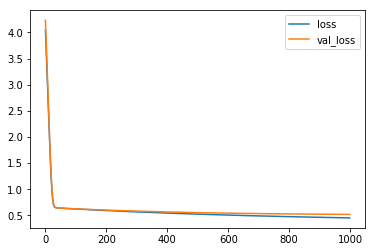

In [12]:
plt.plot(model.loss, label="loss")
plt.plot(model.val_loss, label="val_loss")
plt.legend()
plt.show()

### 【問題7】決定領域の可視化
決定領域を可視化してください。

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region',
                    xlabel='sepal_length', ylabel='petal_length', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5,
                                              np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5,
                                              np.max(X[:,1])+0.5, step))

    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80,
                    color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [14]:
X2 = df.iloc[:, [0, 2]].values
y2 = df.loc[:, "Species"].values
y2 = np.where(y==1, 0, 1) #ラベルを0, 1に変換
display(X2)
display(y2)

array([[7. , 4.7],
       [6.4, 4.5],
       [6.9, 4.9],
       [5.5, 4. ],
       [6.5, 4.6],
       [5.7, 4.5],
       [6.3, 4.7],
       [4.9, 3.3],
       [6.6, 4.6],
       [5.2, 3.9],
       [5. , 3.5],
       [5.9, 4.2],
       [6. , 4. ],
       [6.1, 4.7],
       [5.6, 3.6],
       [6.7, 4.4],
       [5.6, 4.5],
       [5.8, 4.1],
       [6.2, 4.5],
       [5.6, 3.9],
       [5.9, 4.8],
       [6.1, 4. ],
       [6.3, 4.9],
       [6.1, 4.7],
       [6.4, 4.3],
       [6.6, 4.4],
       [6.8, 4.8],
       [6.7, 5. ],
       [6. , 4.5],
       [5.7, 3.5],
       [5.5, 3.8],
       [5.5, 3.7],
       [5.8, 3.9],
       [6. , 5.1],
       [5.4, 4.5],
       [6. , 4.5],
       [6.7, 4.7],
       [6.3, 4.4],
       [5.6, 4.1],
       [5.5, 4. ],
       [5.5, 4.4],
       [6.1, 4.6],
       [5.8, 4. ],
       [5. , 3.3],
       [5.6, 4.2],
       [5.7, 4.2],
       [5.7, 4.2],
       [6.2, 4.3],
       [5.1, 3. ],
       [5.7, 4.1],
       [6.3, 6. ],
       [5.8, 5.1],
       [7.1,

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=0.8, random_state=0)

model2 = ScratchLogisticRegression(num_iter=1000, lr=0.01, verbose=False, no_bias=False)
model2.fit(X_train2, y_train2, X_test2, y_test2)

/Users/itonaoki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


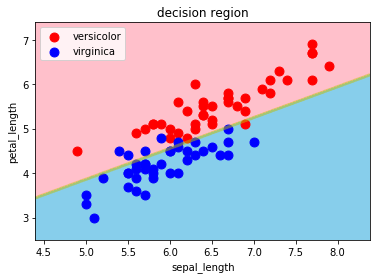

In [16]:
decision_region(X_train2, y_train2, model2)

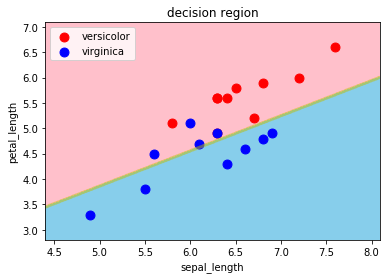

In [17]:
decision_region(X_test2, y_test2, model2)